# [Weather data and solar radiation](01WeatherData.ipynb)

# [Thermal circuit and state-space representation for a thermal circuit with capacities in every node: simple wall](02SimpleWall.ipynb)

# [Thermal circuit and state-space representation for a thermal circuit with capacities in some nodes: cubic building](03CubicBuilding.ipynb)

# [Thermal circuits assembling](04AssemblingCircuits.ipynb)

# Switch between models: heating & cooling and free-running

**Objectives:**
- Implement controller with [deadband](https://en.m.wikipedia.org/wiki/Deadband). 
- Switch between modeles during the numerical integration. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem
import tuto

Let's consider a location and time period for simulation of the toy model presented in tutorials 3 `t03CubeFB.ipynb` and 4 `t04AssTC.ipynb`.

In [2]:
filename = './weather_data/FRA_Lyon.074810_IWEC.epw'

start_date = '2000-05-01 00:00:00'
end_date = '2000-05-22 00:00:00'

## Model for building in free-running

The building is in free running (the indoor temperature is free-floating) if the P-controller is not effective, i.e. $K_p \rightarrow 0$.

In [3]:
Kpf = 1e-3   # no controller Kp -> 0
TCa = tuto.thermal_circuit(Kpf)
[Af, Bf, Cf, Df] = dm4bem.tc2ss(
    TCa['A'], TCa['G'], TCa['b'], TCa['C'], TCa['f'], TCa['y'])
dt_max = min(-2. / np.linalg.eig(Af)[0])
print(f'Maximum time step in free-floating is {dt_max:.2f} s')

Maximum time step in free-floating is 479.08 s


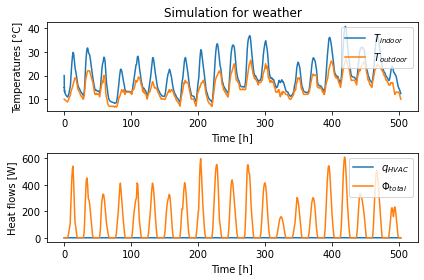

In [4]:
dt = 400   # time step, s
y, q_HVAC = tuto.P_control(filename, start_date, end_date, dt,
                           Af, Bf, Cf, Df, Kpf)

> Figure 1. Simulation in free-running with weather data using Euler explicit method of integration and a time step of 400 s. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

Since the building is in free-running, the energy consumption for HVAC is zero, $Q_{HVAC} = 0 \text{ J}$.

The energy consumption over the time range $[0,\, t_{final}]$ is:

$$ Q_{HVAC} = \int_{0}^{t_{final}} \left |  q_{HVAC}  \right | \,dt$$
$$= \Delta t \sum_{k=0}^{n} \left |q_{HVAC(k)} \right| \text{ [J]}$$
$$= \frac{1}{3.6·10^{6}}
\Delta t \sum_{k=0}^{n}\left |q_{HVAC(k)} \right| \text{ [kW h]}$$

where:
- $\Delta t$ is the time step, s.
- $\left |q_{HVAC(k)} \right|$ - absolute values of the vector of heat flow rates, W.

In [5]:
print(f"Q_HVAC = {dt * sum(abs(q_HVAC)) / 1000 / 3600:.1f} kW·h")

Q_HVAC = 0.0 kW·h


## Model for building with "perfect" proportional controller
A "perfect" proportional controller would have an infinite gain, $K_p \rightarrow \infty$. The change in the controller gain implies a change of the maximum time step.

In [6]:
Kpc = 1e3   # perfect controller Kp -> ∞
TCa = tuto.thermal_circuit(Kpc)
[Ac, Bc, Cc, Dc] = dm4bem.tc2ss(
    TCa['A'], TCa['G'], TCa['b'], TCa['C'], TCa['f'], TCa['y'])
dt_max = min(-2. / np.linalg.eig(Ac)[0])
print(f'For Kp = {Kpc:.0e}, the maximum time step is {dt_max:.2f} s')

For Kp = 1e+03, the maximum time step is 58.92 s


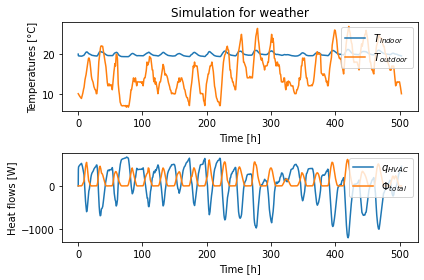

In [7]:
dt = 50     # time step, s
y, q_HVAC = tuto.P_control(filename, start_date, end_date, dt,
                           Ac, Bc, Cc, Dc, Kpc)

> Figure 2. Simulation of an almost perfect controller with weather data using Euler explicit method of integration and a time step of 50 s. a) Indoor and outdoor temperatures. b) Solar and HVAC heat flow rates.

In the case of an almost perfect controller, the indoor temperature is maintained rather constant and the HVAC heat flow rate $q_{HVAC}$ is positive for heating and negative for cooling.

The energy consumption over the time range $[0, t_{final}]$ is:

$$ Q_{HVAC} = \frac{1}{3.6·10^{6}}
\Delta t \sum_{k=0}^{n}\left |q_{HVAC(k)} \right| \text{ [kW h]}$$

where:
- $\Delta t$ is the time step, s.
- $q_{(k)HVAC}$ - the values of the vector of heat flow rates, W.

In [8]:
print(f"Q_HVAC = {dt * sum(abs(q_HVAC)) / 1000 / 3600:.1f} kW·h")

Q_HVAC = 168.0 kW·h


## Heating and cooling with dead band

Maintaing the indoor temperature at a constant level is not energy efficient. It is preferable to have a [deadband](https://en.m.wikipedia.org/wiki/Deadband) for the indoor temperature in which the building is in free running and to use the HVAC system when the indoor temperature is out the deadband.

An appraoch for the simulation of heating and cooling with deadband is to use both models, free-running and perfect controlled. In this case, the time step is the minimum between the two time steps.

The code is implemented in function `tuto.switch_models()` which  is very similar to the function `tuto.P_control()`. The differences consist in:

- initilization: `switch_models()` contains in addition:

>     # initial values
    temp_exp = 0 * np.ones([Af.shape[0], u.shape[0]])
    temp_exp[:, 0] = data['Ti'][0]
    y = np.zeros(u.shape[0])
    y[0] = data['Ti'][0]
    qHVAC = 0 * np.ones(u.shape[0])

- integration in time: `switch_models()` switches between perfect controller (index `c`) and free-running (index `f`) models and calculates the energy consumption at every time step:

>     # integration in time
    I = np.eye(Af.shape[0])
    for k in range(u.shape[0] - 1):
        if y[k] < data['Ti'][k] or y[k] > DeltaT + data['Ti'][k]:
            temp_exp[:, k + 1] = (I + dt * Ac) @ temp_exp[:, k]\
                + dt * Bc @ u.iloc[k, :]
            y[k + 1] = Cc @ temp_exp[:, k + 1] + Dc @ u.iloc[k]
            qHVAC[k + 1] = Kpc * (data['Ti'][k + 1] - y[k + 1])
        else:
            temp_exp[:, k + 1] = (I + dt * Af) @ temp_exp[:, k]\
                + dt * Bf @ u.iloc[k, :]
            y[k + 1] = Cf @ temp_exp[:, k + 1] + Df @ u.iloc[k]
            qHVAC[k + 1] = 0

For the indoor temperature setpoint `Tisp` and the accepted deadband in temperature `DeltaT`.

In [9]:
θ_isp = 20  # indoor temperature setpoint, °C
Δθ = 2.5    # deadband of indoor temperature, °C

### Large proportional gain for the controller
If the controller has a large proportional gain, the temperature is maintained in the limits. However, the heat flow of the HVAC system and the indoor tempertaure vary too quickly, phenomena called *pumping*  (Figure 3). Pumping is different of [instability](https://en.m.wikipedia.org/wiki/Instability#Instability_in_control_systems) in the sens that the variables have limited values between bounds. Pumping is characterized by repeated oscilation between the bounds of the variables which causes [wear and tear](https://en.wikipedia.org/wiki/Wear_and_tear) of the equipement.

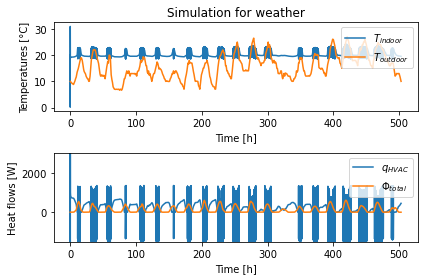

In [10]:
Kpc = 1e3   # no controller Kp -> 0
TCa = tuto.thermal_circuit(Kpc)
[Ac, Bc, Cc, Dc] = dm4bem.tc2ss(
    TCa['A'], TCa['G'], TCa['b'], TCa['C'], TCa['f'], TCa['y'])
y, q_HVAC = tuto.switch_models(filename, start_date, end_date, dt,
                               Af, Bf, Cf, Df, Kpf,
                               Ac, Bc, Cc, Dc, Kpc,
                               θ_isp, Δθ)

> Figure 3. Simulation of heating and cooling with deadband by using a high gain controller. a) Indoor and outdoor temperature. b) Solar and HVAC heat flow rates.


In [11]:
print(f"Q_HVAC = {dt * sum(abs(q_HVAC)) / 1000 / 3600:.1f} kW·h")

Q_HVAC = 179.9 kW·h


### Large proportional gain for the controller with reduced time step

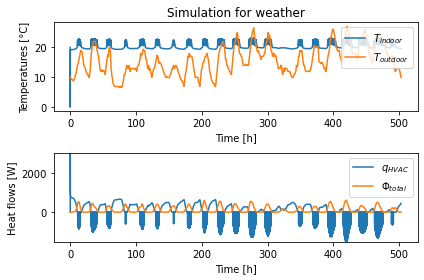

In [12]:
dt = 25     # time step, s
Kpc = 1e3   # controller Kp -> ∞
TCa = tuto.thermal_circuit(Kpc)
[Ac, Bc, Cc, Dc] = dm4bem.tc2ss(
    TCa['A'], TCa['G'], TCa['b'], TCa['C'], TCa['f'], TCa['y'])
y, q_HVAC = tuto.switch_models(filename, start_date, end_date, dt,
                               Af, Bf, Cf, Df, Kpf,
                               Ac, Bc, Cc, Dc, Kpc,
                               θ_isp, Δθ)

> Figure 4. Heating and cooling with deadband, high Kp and small time step. a) Indoor and outdoor temperature. b) Solar and HVAC heat flow rates.

Note that the energy consumption depends on the time step.

In [13]:
print(f"Q_HVAC = {dt * sum(abs(q_HVAC)) / 1000 / 3600:.1f} kW·h")

Q_HVAC = 114.6 kW·h


### Optimal controller gain

The instability or *pumping* effect may be reduced by using a smaller gain for the controller.

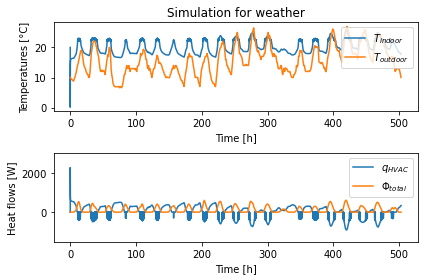

In [15]:
dt = 50     # time step, s
Kpc = 1.5e2 # controller Kp
TCa = tuto.thermal_circuit(Kpc)
[Ac, Bc, Cc, Dc] = dm4bem.tc2ss(
    TCa['A'], TCa['G'], TCa['b'], TCa['C'], TCa['f'], TCa['y'])
y, q_HVAC = tuto.switch_models(filename, start_date, end_date, dt,
                               Af, Bf, Cf, Df, Kpf,
                               Ac, Bc, Cc, Dc, Kpc,
                               θ_isp, Δθ);

> Figure 5. Heating and cooling with dead-band and a sub-optimal gain for the controller. a) Indoor and outdoor temperature. b) Solar and HVAC heat flow rates.

The energy consumption is significantly smaller as compared with the "perfect" controller.

In [16]:
print(f"Q_HVAC = {sum(dt * abs(q_HVAC)) / 1000 / 3600:.1f} kW·h")

Q_HVAC = 119.5 kW·h


## Only heating

If there is only heating, then the HVAC system controls the indoor temperature when it is smaller than the setpoint and leaves the building in free running if the indor temperature is larger than the setpoint.

Heating is implemented in `tuto.heat()` function, which is similar to `switch_models()` fuction with the exception of the numerical integration.

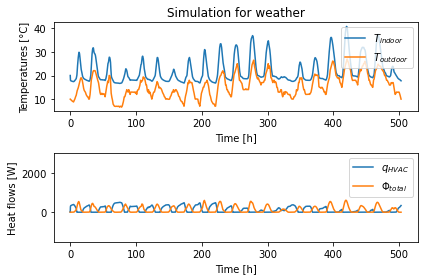

In [17]:
y, q_HVAC = tuto.heat(filename, start_date, end_date, dt,
                      Af, Bf, Cf, Df, Kpf,
                      Ac, Bc, Cc, Dc, Kpc,
                      θ_isp, Δθ)

> Figure 6. Heating. a) Indoor and outdoor temperature. b) Solar and HVAC heat flow rates.

If only heating is used, Tthe energy consumption is smaller, but there is overheating.

In [18]:
print(f"Q_HVAC = {dt * sum(abs(q_HVAC)) / 1000 / 3600:.1f} kW·h")

Q_HVAC = 66.2 kW·h


# [Control input: heating & cooling and free-running](06Control_Input.ipynb)